# Crypto Altcoin Analysis
This workbook will walk through extracting data from Coinbase on all altcoins available with a USD pairing, then clean data and do some performance and correlation analysis.



In [30]:
# Imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from pathlib import Path
from dotenv import load_dotenv
import csv
import cbpro
import requests
import time


In [31]:
# Setup Public Client for Coinbase
public_client = cbpro.PublicClient()

In [32]:
# Pull a list of all currencies (Assets and pairings)
currency_response_list = public_client.get_currencies()

In [4]:
# Pull only the assets that are marked as crypto

# Create empty list of cryptos
crypto_list = []

# If the asset is labeled as a crypto add to crypto list
for asset in currency_response_list:
    if asset['details']['type'] == 'crypto':
        crypto_list.append(asset['id'])
crypto_list.sort()
print(crypto_list)
print(len(crypto_list))

['1INCH', 'AAVE', 'ACH', 'ADA', 'ALGO', 'AMP', 'ANKR', 'ATOM', 'AXS', 'BAL', 'BAND', 'BAT', 'BCH', 'BNT', 'BOND', 'BTC', 'CGLD', 'CHZ', 'CLV', 'COMP', 'CRV', 'CTSI', 'CVC', 'DAI', 'DASH', 'DNT', 'DOGE', 'DOT', 'ENJ', 'EOS', 'ETC', 'ETH', 'FARM', 'FET', 'FIL', 'FORTH', 'GNT', 'GRT', 'GTC', 'ICP', 'IOTX', 'KEEP', 'KNC', 'LINK', 'LOOM', 'LPT', 'LRC', 'LTC', 'MANA', 'MASK', 'MATIC', 'MIR', 'MKR', 'MLN', 'NKN', 'NMR', 'NU', 'OGN', 'OMG', 'ORN', 'OXT', 'PAX', 'PLA', 'POLY', 'QNT', 'QUICK', 'RAI', 'REN', 'REP', 'REQ', 'RLC', 'RLY', 'SHIB', 'SKL', 'SNX', 'SOL', 'STORJ', 'SUSHI', 'TRB', 'TRIBE', 'TRU', 'UMA', 'UNI', 'USDC', 'USDT', 'UST', 'WBTC', 'WLUNA', 'XLM', 'XRP', 'XTZ', 'YFI', 'ZEC', 'ZRX']
94


In [33]:
# Get a list of all Coinbase Products
all_products_list = public_client.get_products()
print(len(all_products_list))
#all_products_list

277


In [6]:
# Find product ids that have a USD quote_currency and create a list

# Create Empty List for USD paired products
usd_product_id_list = []
for product in all_products_list:
    if product['quote_currency'] == 'USD':
        usd_product_id_list.append(product['id'])
usd_product_id_list.sort()
print(usd_product_id_list)

['1INCH-USD', 'AAVE-USD', 'ACH-USD', 'ADA-USD', 'ALGO-USD', 'AMP-USD', 'ANKR-USD', 'ATOM-USD', 'AXS-USD', 'BAL-USD', 'BAND-USD', 'BAT-USD', 'BCH-USD', 'BNT-USD', 'BOND-USD', 'BTC-USD', 'CGLD-USD', 'CHZ-USD', 'CLV-USD', 'COMP-USD', 'CRV-USD', 'CTSI-USD', 'DAI-USD', 'DASH-USD', 'DOGE-USD', 'DOT-USD', 'ENJ-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FARM-USD', 'FET-USD', 'FIL-USD', 'FORTH-USD', 'GRT-USD', 'GTC-USD', 'ICP-USD', 'IOTX-USD', 'KEEP-USD', 'KNC-USD', 'LINK-USD', 'LPT-USD', 'LRC-USD', 'LTC-USD', 'MANA-USD', 'MASK-USD', 'MATIC-USD', 'MIR-USD', 'MKR-USD', 'MLN-USD', 'NKN-USD', 'NMR-USD', 'NU-USD', 'OGN-USD', 'OMG-USD', 'ORN-USD', 'OXT-USD', 'PAX-USD', 'PLA-USD', 'POLY-USD', 'QNT-USD', 'QUICK-USD', 'RAI-USD', 'REN-USD', 'REP-USD', 'REQ-USD', 'RLC-USD', 'RLY-USD', 'SKL-USD', 'SNX-USD', 'SOL-USD', 'STORJ-USD', 'SUSHI-USD', 'TRB-USD', 'TRIBE-USD', 'TRU-USD', 'UMA-USD', 'UNI-USD', 'USDT-USD', 'UST-USD', 'WBTC-USD', 'WLUNA-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD', 'ZEC-USD', 'ZRX-USD']


In [7]:
# Make calls to the Products endpoint for each product_Id and pull candlestick data for the last 300 weeks
# GET https://api.pro.coinbase.com/products/<product-id>/candles
# Reponses contain the following metrics in a list of lists.
# [0] time bucket start time
# [1] low lowest price during the bucket interval
# [2] high highest price during the bucket interval
# [3] open opening price (first trade) in the bucket interval
# [4] close closing price (last trade) in the bucket interval
# [5] volume volume of trading activity during the bucket interval
# columns1 = ['Date'] + usd_product_id_list

def pull_historical_data(start,end):
    temp_df = pd.DataFrame()
    for item in good_list:
        historical = pd.DataFrame(public_client.get_product_historic_rates(item, start=start, end=end, granularity=86400))
        historical.columns=["Date","Open","High","Low",item,"Volume"]
        historical['Date'] = pd.to_datetime(historical['Date'], unit='s')
        historical.set_index('Date', inplace=True)
        historical.sort_values(by='Date', ascending=True, inplace=True)
        historical = historical.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
        temp_df = pd.concat([temp_df, historical], axis=1)
    # print(f"temp_df 1: {temp_df}")
    return temp_df


main_df = pd.DataFrame()

# Apparently only some of these product ID's have data going back to 2019 - these are those
good_list = ['ALGO-USD', 'BCH-USD', 'BTC-USD', 'DASH-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'LINK-USD', 'LTC-USD', 'REP-USD', 'XLM-USD', 'XTZ-USD', 'ZRX-USD']        
    

date_start1 = '2019-01-01T00:00:00-06:00'
date_end1 = '2019-10-19T00:00:00-05:00'
date_start2 = '2019-10-20T00:00:00-06:00'
date_end2 = '2020-05-19T00:00:00-05:00'
date_start3 = '2020-05-20T00:00:00-06:00'
date_end3 ='2020-10-19T00:00:00-05:00'
date_start4 = '2020-10-20T00:00:00-06:00'
date_end4 = '2021-05-19T00:00:00-05:00'
date_start5 = '2021-05-20T00:00:00-06:00'
date_end5 ='2021-08-04T00:00:00-05:00'

main_df = pull_historical_data(date_start1, date_end1)
# clean up null values
main_df = main_df.dropna()
temp_df = pull_historical_data(date_start2, date_end2)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start3, date_end3)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start4, date_end4)
main_df = pd.concat([main_df, temp_df], axis=0)
temp_df = pull_historical_data(date_start5, date_end5)
main_df = pd.concat([main_df, temp_df], axis=0)

main_df


,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2019-09-17,0.3190,318.18,10185.39,94.337,4.067,6.279,207.95,1.62707,74.13,10.61,0.063411,1.1104,0.174939
2019-09-18,0.3411,324.04,10155.26,97.646,4.081,6.388,210.27,1.80999,77.75,10.73,0.082876,1.0861,0.192772
2019-09-19,0.3222,323.80,10275.01,99.935,3.968,6.226,220.80,1.87800,76.82,10.71,0.080944,1.0891,0.228500
2019-09-20,0.3201,315.75,10168.85,96.650,4.014,6.160,218.06,1.82052,75.10,10.91,0.071933,1.0628,0.232041
2019-09-21,0.3157,311.60,9973.99,92.817,3.997,6.114,214.80,1.88000,73.18,10.75,0.069626,1.0725,0.247124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,0.8399,546.05,41495.01,163.501,4.073,51.317,2533.74,22.73065,144.43,27.37,0.284683,3.0384,0.818632
2021-08-01,0.8123,526.31,39865.41,160.131,3.939,50.281,2555.43,22.07602,140.28,26.90,0.275100,2.9505,0.779933
2021-08-02,0.8166,543.31,39149.59,161.780,4.024,51.290,2608.12,23.48414,141.36,27.01,0.274201,3.1291,0.816104


# Crypto Altcoin Analysis
This workbook will walk through extracting data from Coinbase on all altcoins available with a USD pairing, then clean data and do some performance and correlation analysis.



In [8]:
main_df = main_df.dropna()
main_df


,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2019-09-17,0.3190,318.18,10185.39,94.337,4.067,6.279,207.95,1.62707,74.13,10.61,0.063411,1.1104,0.174939
2019-09-18,0.3411,324.04,10155.26,97.646,4.081,6.388,210.27,1.80999,77.75,10.73,0.082876,1.0861,0.192772
2019-09-19,0.3222,323.80,10275.01,99.935,3.968,6.226,220.80,1.87800,76.82,10.71,0.080944,1.0891,0.228500
2019-09-20,0.3201,315.75,10168.85,96.650,4.014,6.160,218.06,1.82052,75.10,10.91,0.071933,1.0628,0.232041
2019-09-21,0.3157,311.60,9973.99,92.817,3.997,6.114,214.80,1.88000,73.18,10.75,0.069626,1.0725,0.247124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,0.8399,546.05,41495.01,163.501,4.073,51.317,2533.74,22.73065,144.43,27.37,0.284683,3.0384,0.818632
2021-08-01,0.8123,526.31,39865.41,160.131,3.939,50.281,2555.43,22.07602,140.28,26.90,0.275100,2.9505,0.779933
2021-08-02,0.8166,543.31,39149.59,161.780,4.024,51.290,2608.12,23.48414,141.36,27.01,0.274201,3.1291,0.816104


In [9]:
main_df.isnull

<bound method DataFrame.isnull of             ALGO-USD  BCH-USD   BTC-USD  DASH-USD  EOS-USD  ETC-USD  ETH-USD  \
Date                                                                           
2019-09-17    0.3190   318.18  10185.39    94.337    4.067    6.279   207.95   
2019-09-18    0.3411   324.04  10155.26    97.646    4.081    6.388   210.27   
2019-09-19    0.3222   323.80  10275.01    99.935    3.968    6.226   220.80   
2019-09-20    0.3201   315.75  10168.85    96.650    4.014    6.160   218.06   
2019-09-21    0.3157   311.60   9973.99    92.817    3.997    6.114   214.80   
...              ...      ...       ...       ...      ...      ...      ...   
2021-07-31    0.8399   546.05  41495.01   163.501    4.073   51.317  2533.74   
2021-08-01    0.8123   526.31  39865.41   160.131    3.939   50.281  2555.43   
2021-08-02    0.8166   543.31  39149.59   161.780    4.024   51.290  2608.12   
2021-08-03    0.8188   538.50  38191.44   156.420    4.022   49.356  2508.31   
2021-0

In [10]:
main_df.isnull().sum()

ALGO-USD    0
BCH-USD     0
BTC-USD     0
DASH-USD    0
EOS-USD     0
ETC-USD     0
ETH-USD     0
LINK-USD    0
LTC-USD     0
REP-USD     0
XLM-USD     0
XTZ-USD     0
ZRX-USD     0
dtype: int64

<AxesSubplot:xlabel='Date'>

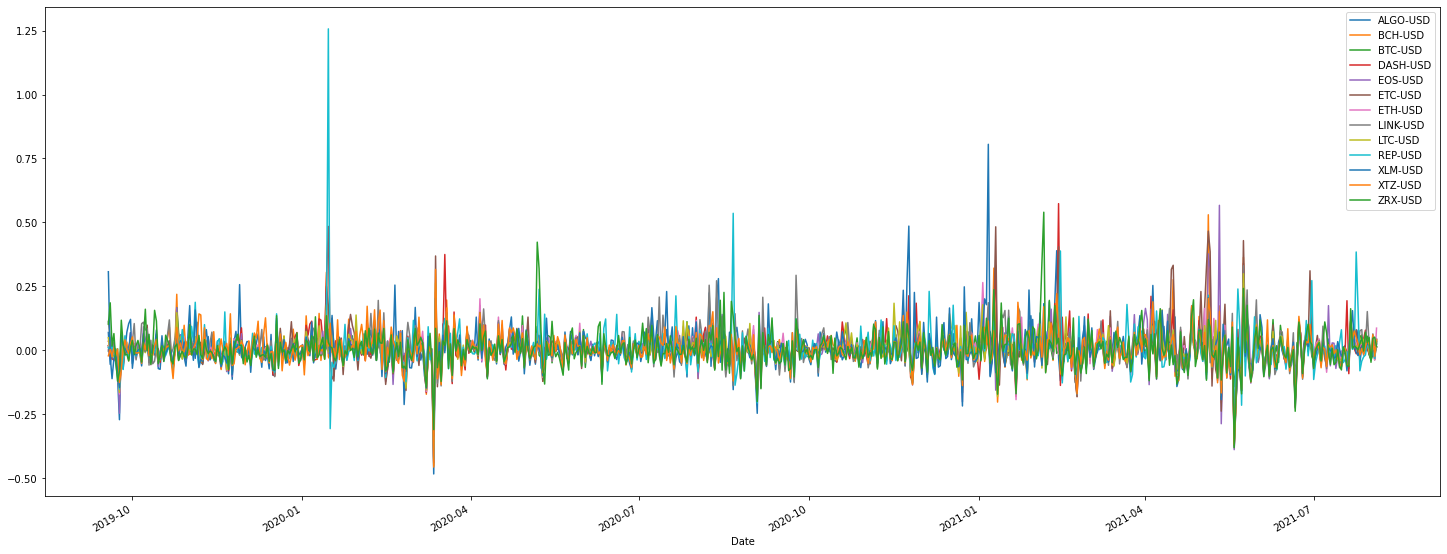

In [11]:
main_crypto_change = main_df.pct_change()
main_crypto_change.plot(figsize=(25,10))

<AxesSubplot:xlabel='Date'>

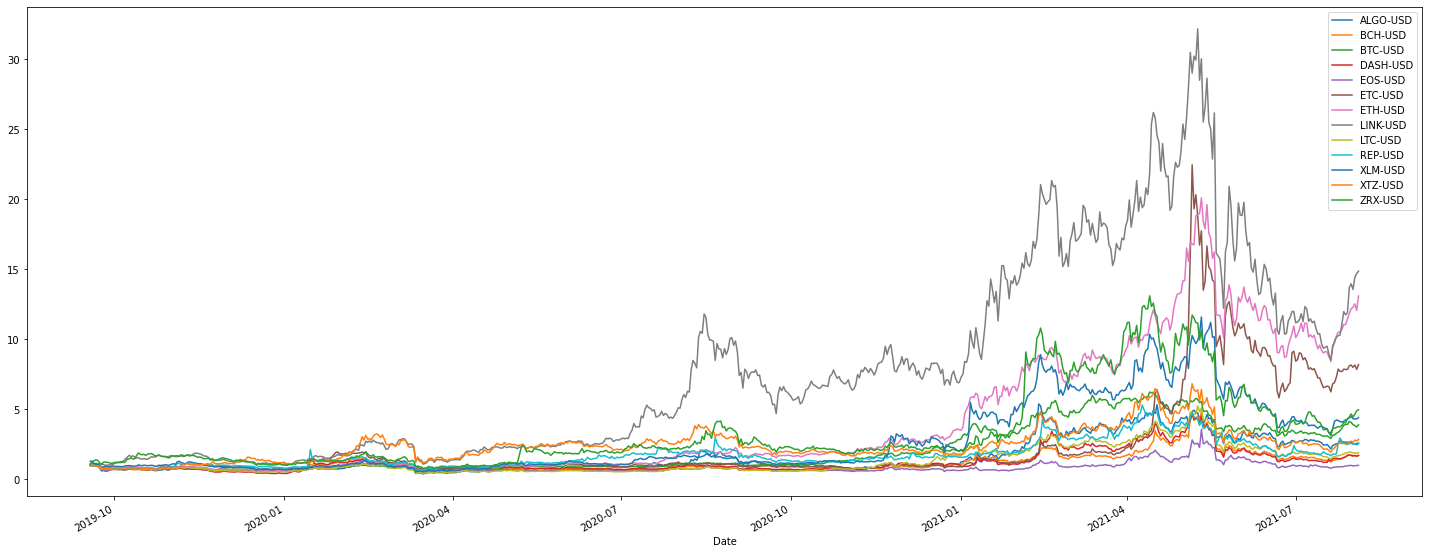

In [12]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + main_crypto_change).cumprod() 
cumulative_returns
# Plot cumulative returns
cumulative_returns.plot(figsize=(25,10))

In [13]:
final_alt_returns = cumulative_returns[-1:]
final_alt_returns

,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
Date,,,,,,,,,,,,,
2021-08-04,2.597492,1.714816,3.89994,1.713315,1.013278,8.205606,13.102717,14.872593,1.922838,2.548539,4.425226,2.85915,4.9755


## Figure out how to PLot bar chart with x-axes as the ALt pairings - Pete

<AxesSubplot:xlabel='Date'>

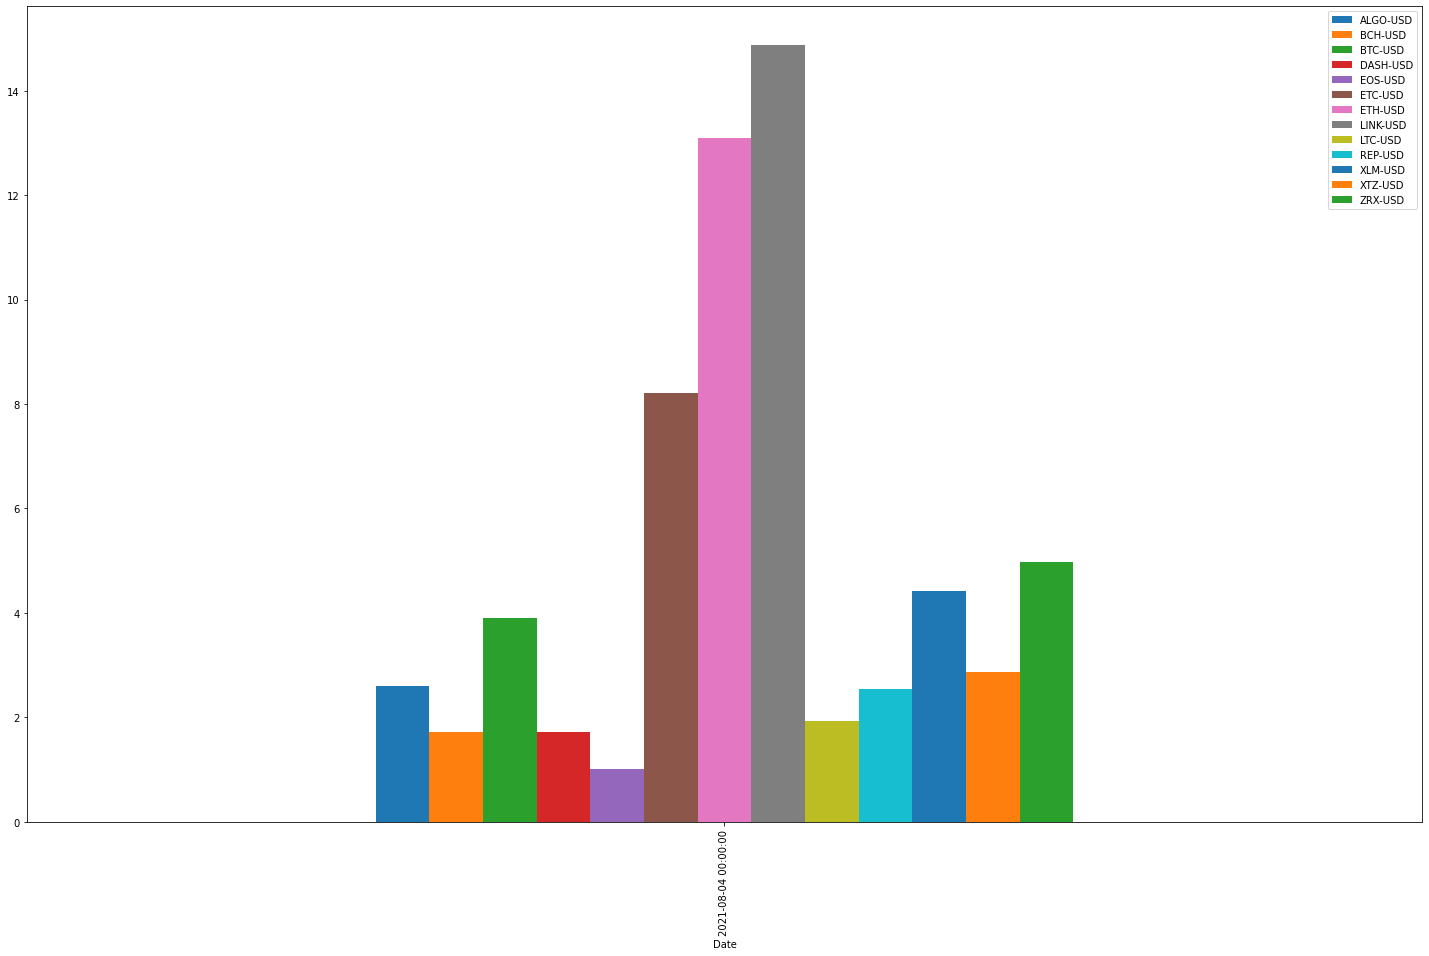

In [14]:
final_alt_returns.plot( kind='bar', figsize=(25,15))

<AxesSubplot:>

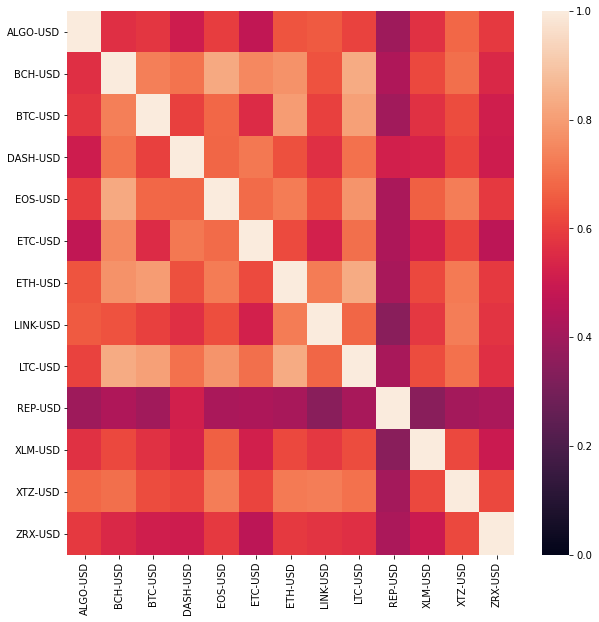

In [15]:
import seaborn as sns
correlation = main_crypto_change.corr()
# Display de correlation matrix
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(correlation, vmin=-0, vmax=1, ax=ax)

In [16]:
corr = main_crypto_change.corr()
corr

,ALGO-USD,BCH-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,LINK-USD,LTC-USD,REP-USD,XLM-USD,XTZ-USD,ZRX-USD
ALGO-USD,1.000000,0.566349,0.582014,0.506173,0.594025,0.473496,0.644461,0.652408,0.609352,0.390840,0.569561,0.682953,0.588991
BCH-USD,0.566349,1.000000,0.732624,0.703305,0.830016,0.750837,0.775341,0.639750,0.834989,0.431344,0.619843,0.696747,0.544121
BTC-USD,0.582014,0.732624,1.000000,0.603162,0.679846,0.553466,0.799332,0.602015,0.806922,0.400421,0.569914,0.625206,0.513411
DASH-USD,0.506173,0.703305,0.603162,1.000000,0.679317,0.717676,0.636004,0.563195,0.699346,0.518155,0.530602,0.610187,0.504607
EOS-USD,0.594025,0.830016,0.679846,0.679317,1.000000,0.690438,0.722780,0.632200,0.779838,0.418481,0.666051,0.727681,0.587124
ETC-USD,0.473496,0.750837,0.553466,0.717676,0.690438,1.000000,0.622030,0.521710,0.696610,0.427229,0.517731,0.612578,0.462292
ETH-USD,0.644461,0.775341,0.799332,0.636004,0.722780,0.622030,1.000000,0.723630,0.833171,0.415562,0.619279,0.721502,0.586902
LINK-USD,0.652408,0.639750,0.602015,0.563195,0.632200,0.521710,0.723630,1.000000,0.676797,0.347062,0.583824,0.726603,0.575491
LTC-USD,0.609352,0.834989,0.806922,0.699346,0.779838,0.696610,0.833171,0.676797,1.000000,0.414791,0.625526,0.700273,0.566308
REP-USD,0.390840,0.431344,0.400421,0.518155,0.418481,0.427229,0.415562,0.347062,0.414791,1.000000,0.347526,0.406666,0.424476


<AxesSubplot:>

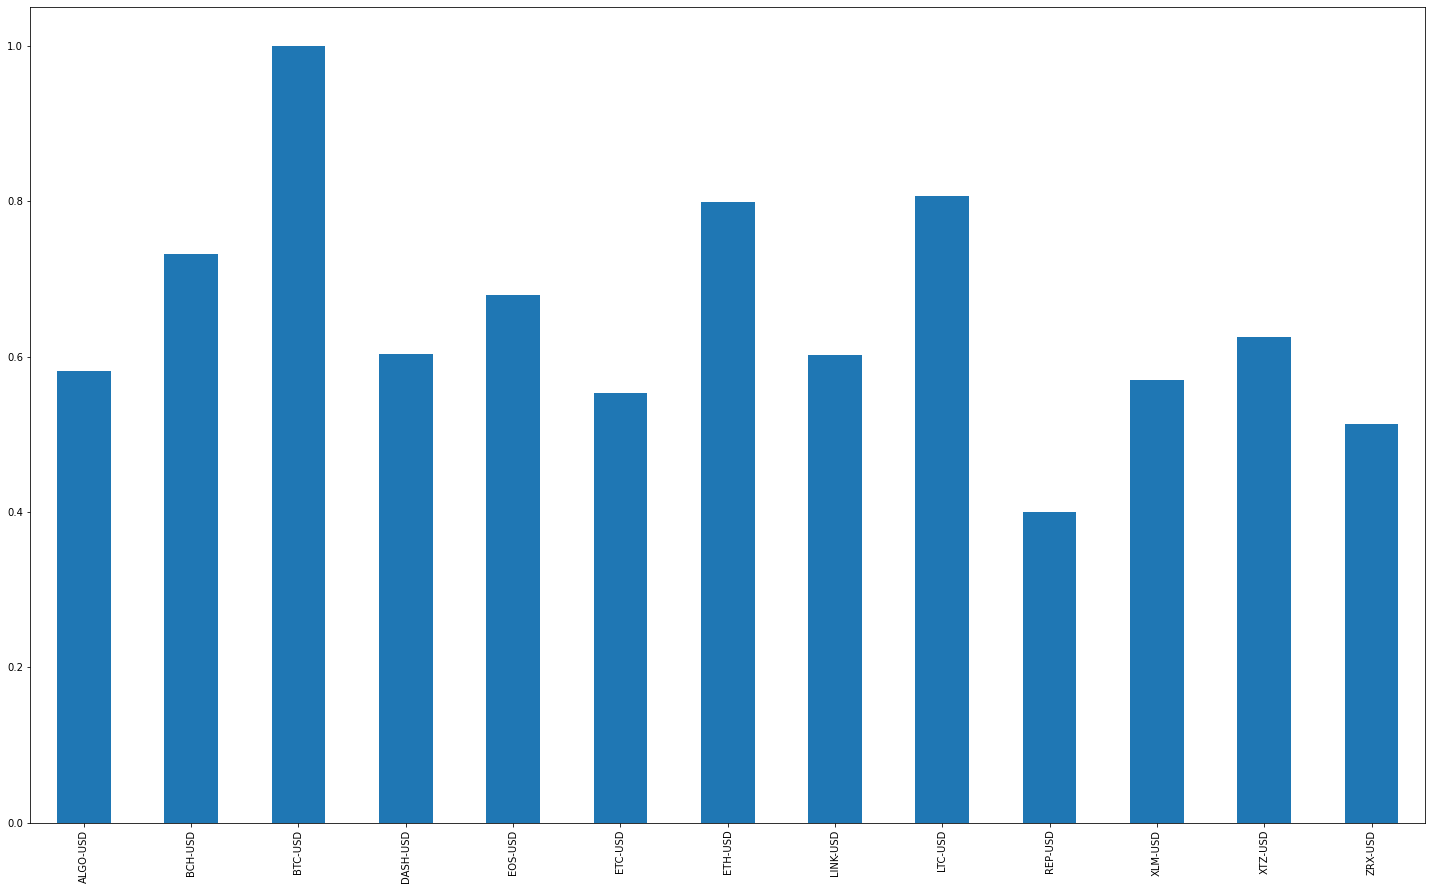

In [17]:
btc_corr = corr['BTC-USD']
btc_corr.plot( kind='bar', figsize=(25,15))



# Create Crypto Portfolios - Starting Capital = $10,000

## Portfolio # 1 - 50% BTC 50% even distributions alts

In [18]:
# Code Here
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(.5/12), (.5/12), .5, (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12), (.5/12)]

portfolio_1_returns = cumulative_returns.dot(weights).dropna()
portfolio_1_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


Date
2019-09-18    1.028284
2019-09-19    1.041044
2019-09-20    1.024820
2019-09-21    1.013566
2019-09-22    1.002012
                ...   
2021-07-31    4.447174
2021-08-01    4.315842
2021-08-02    4.354167
2021-08-03    4.285004
2021-08-04    4.447931
Length: 683, dtype: float64

## Portfolio #2 - 50% BTC 25% ETH 25% evenly distributed Alts - Pete

In [19]:
# Code Here
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(.25/11), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

portfolio_2_returns = cumulative_returns.dot(weights).dropna()
portfolio_2_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


Date
2019-09-18    0.996249
2019-09-19    1.017405
2019-09-20    1.003715
2019-09-21    0.989935
2019-09-22    0.981082
                ...   
2021-07-31    6.085352
2021-08-01    6.002341
2021-08-02    6.063755
2021-08-03    5.895878
2021-08-04    6.254954
Length: 683, dtype: float64

## Portfolio #3 - Totally even distribution - KAI

In [20]:
# Code Here - KAI
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13), (1/13)]
portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns
# calculate end value of portfolio by multiplying the inital investment 10k by the end return
Portfolio_3 = portfolio_3_returns[-1] * 10000
Portfolio_3
print(f" Portfolio 3 Return is: ${Portfolio_3.round(2)}")\


Date
2019-09-18    1.054200
2019-09-19    1.072145
2019-09-20    1.058098
2019-09-21    1.043570
2019-09-22    1.032101
                ...   
2021-07-31    6.228044
2021-08-01    6.140345
2021-08-02    6.202490
2021-08-03    6.034987
2021-08-04    6.395728
Length: 683, dtype: float64

## Portfolio #4 - Weighted Distribution based on Market Cap - Challenging - Nozie

In [45]:
# Code Here - market cap for each alt/BTC at 2019-09-18 
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD

# Manually enter market caps per alt`
MarketCap = {"Algo": 2838132484,
"BTC":855091881134,
"DASH":1797953721,
"EOS":4428517660,
"ETC":7562792807,
"ETH":369274060785,
"LINK":10902129329,
"LTC":11033939584,
"REP":183712556,
"XLM":7448463757,
"XTZ":2800264777,
"ZRX":818423480} 

# Sum all market caps
sum(MarketCap.values())
    
# Find out percentage of total market cap for each alt`
for Alt in MarketCap:
    percentage=MarketCap[Alt]/sum(MarketCap.values())*100
    print(Alt,'->',float('{0:.2f}'.format(percentage))) 

    # Figure out weights
weights = [(1/13), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

# set the Percentages equal to the weights
for Alt in MarketCap:
    for weight in weights:
        percentage=MarketCap[Alt]/sum(MarketCap.values())*100
        print(percentage,'->',weight)


portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return
end_value=portfolio_3_returns*10_000
end_value


Algo -> 0.22
BTC -> 67.11
DASH -> 0.14
EOS -> 0.35
ETC -> 0.59
ETH -> 28.98
LINK -> 0.86
LTC -> 0.87
REP -> 0.01
XLM -> 0.58
XTZ -> 0.22
ZRX -> 0.06
0.22274183223542884 -> 0.07692307692307693
0.22274183223542884 -> 0.002066115702479339
0.22274183223542884 -> 0.5
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.25
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
0.22274183223542884 -> 0.022727272727272728
67.10917598356437 -> 0.07692307692307693
67.10917598356437 -> 0.002066115702479339
67.10917598356437 -> 0.5
67.10917598356437 -> 0.022727272727272728
67.10917598356437 -> 0.022727272727272728
67.10917598356437 -> 0.022727272727272728
67.10917598356437 -> 0.25
67.10917598356437 -> 0.022727272727272728
67.10917598

Date
2019-09-18    10541.997324
2019-09-19    10721.446719
2019-09-20    10580.975890
2019-09-21    10435.704762
2019-09-22    10321.011221
                  ...     
2021-07-31    62280.444804
2021-08-01    61403.448607
2021-08-02    62024.897151
2021-08-03    60349.865435
2021-08-04    63957.276447
Length: 683, dtype: float64

## Portfolio #5 - Alek - Up to him!

In [ ]:
# Code Here - market cap for each alt/BTC at 2019-09-18 
# Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return
# ALGO-USD	BCH-USD	BTC-USD	DASH-USD EOS-USD ETC-USD ETH-USD LINK-USD LTC-USD REP-USD XLM-USD XTZ-USD ZRX-USD
weights = [(1/13), (.25/121), .5, (.25/11), (.25/11), (.25/11), .25, (.25/11), (.25/11), (.25/11), (.25/11), (.25/11), (.25/11)]

portfolio_3_returns = cumulative_returns.dot(weights).dropna()
portfolio_3_returns

# calculate end value of portfolio by multiplying the inital investment 10k by the end return


## Portfolio #6 - S&P 500 - John

In [ ]:
# use the same thing that was done in the homework